This validation case reproduces TDS measurements of D from EUROFER performed by [K. Schmid et al.](https://www.sciencedirect.com/science/article/pii/S2352179122002228).

Experiments were conducted with three types of EUROFER samples (0.8 mm thick): undamaged, damaged with 20 MeV W ions, loaded with D and then damaged with 20 MeV W ions. These samples were then loaded with low-energy (5 ev/ion) D flux of $\approx9\times10^{19}\,\mathrm{m}^{-2}\mathrm{s}^{-1}$ at the gas pressure of 1 Pa and $T=370$ K. The exposure time varied between 48 h to 143 h resulting in four cases: 
- undamaged sample loaded for 143 h with D (labelled as **143 h plasma**); 
- damaged sample loaded for 48 h with D (labelled as **DPA $\rightarrow$ 48 h plasma**); 
- damaged sample loaded for 143 h with D (labelled as **DPA $\rightarrow$ 143 h plasma**); 
- pre-loaded damaged sample exposed for 48 h with D (labelled as **DPA+D $\rightarrow$ 48 h plasma**). 

After exposure, the samples were stored for $\approx24$ h at $T=290$ K. Finally, TDS measurements up to 800 K were performed.

The FESTIM model is mainly based on the simulations of [K. Schmid et al.](https://www.sciencedirect.com/science/article/pii/S2352179123001333?via%3Dihub) The D diffusivity in EUROFER is taken from the work of [A. Aiello et al.](https://www.tandfonline.com/doi/abs/10.13182/FST41-872) In all cases, intrinsic trapping sites are considered with a homogeneous distribution within the sample. For pre-damaged samples, additional extrinsic traps, distributed within the damaged zone, is included in the simulations. The surface kinetics is determined by adsoption from the gas phase, recombination, and desorption due to the incidence of energetic D ions. Only the front surface is assumed to be subjected to the D flux. 

To reproduce the experimental data, the input parameters for the TESSIM-X simulations, performed by [K. Schmid et al.](https://www.sciencedirect.com/science/article/pii/S2352179123001333?via%3Dihub), were used. The obtained FESTIM results are then compared with experimental and TESSIM-X data.

# FESTIM model

In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy import special
import json

# Monkey patch the C99CodePrinter class
# this is to avoid the bug observed in https://github.com/festim-dev/FESTIM/issues/813
from sympy.printing.c import C99CodePrinter

original_print_function = C99CodePrinter._print_Function
log_bis = sp.Function("std::log")


def _custom_print_Function(self, expr):
    if expr.func == log_bis:
        return f"std::log({self._print(expr.args[0])})"
    return original_print_function(self, expr)


C99CodePrinter._print_Function = _custom_print_Function

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19
M_D2 = 4.028e-3 / N_A_const  # the D2 mass, kg mol^-1

# Exposure conditions
P_D2 = 1  # Pa
T_load = 370  # D loading temperature, K
T_storage = 290  # temperature after cooling phase, K
ramp = 3 / 60  # TDS heating rate, K/s
t_cool = 1000  # colling duration, s
t_storage = 24 * 3600  # storage time, s
t_TDS = (800 - T_storage) / ramp  # TDS duration (up to 800 K), s

# Sample
L = 0.8e-3  # half thickness, m

# EUROFER properties
n_EFe = 8.59e28  # EUROFER atomic concentration, m^-3
n_IS = 6 * n_EFe  # concentration of interstitial sites, m^-3
n_surf = n_EFe ** (2 / 3)  # concentration of adsorption sites, m^-2
lambda_lat = n_EFe ** (-1 / 3)  # Typical lattice spacing, m

D0 = 1.5e-7  # diffusivity pre-factor, m^2 s^-1
E_diff = F.kJmol_to_eV(14.470)  # diffusion activation energy, eV

# Energy landscape
E_bs = E_diff  # energy barrier from bulk to surface transition, eV
nu_bs = (
    D0 / lambda_lat**2 * n_surf / n_EFe
)  # attempt frequency for b-to-s transition, s^-1
E_diss = 0.4  # energy barrier for D2 dissociation, eV
E_rec = 0.63  # energy barrier for D2 recombination, eV
E_sol = 0.238  # heat of solution, eV
S0 = 1.5e-6 * n_EFe  # solubility pre-factor, m^-3 Pa^-0.5
Xi0 = 1e-5  # adsorption rate pre-factor
chi0 = 1e-7  # recombination rate pre-factor
E_sb = (
    E_rec / 2 - E_diss / 2 + E_sol + E_diff
)  # energy barrier from bulk to surface transition, eV

# Trap properties
nu_tr = D0 / lambda_lat**2  # trapping attempt frequency, s^-1
nu_dt = 4.0e13  # detrapping attempt frequency, s^-1
E_tr = E_diff
E_dt_intr = 0.9  # detrapping energy for intrinsic traps, eV
E_dt_dpa = 1.08  # detrapping energy for DPA traps, eV

# Implantation parameters
indicent_flux = 9e19  # irradiation flux, m^-2 s^-1
R_impl = -1.0e-10  # implantation range, m
sigma = 7.5e-10 / np.sqrt(2)
refl_coeff = 0.612  # reflection coefficient


################### FUNCTIONS ###################
def Xi(T):
    # unitless
    return Xi0 * f.exp(-E_diss / F.k_B / T)


def chi(T):
    # in m^2 s^-1
    return chi0 * f.exp(-E_rec / F.k_B / T)


def S(T):
    # solubility m^-3 Pa^-0.5
    return S0 * f.exp(-E_sol / F.k_B / T)


def Psi(T):
    return 1 / f.sqrt(2 * np.pi * M_D2 * F.k_B * T * e)


def k_bs(T, surf_conc, solute_conc, t):
    # n_IS / n_EFe is needed to obtain lambda_abs=n_surf/n_EFe in the final
    # expression for the bulk-to-surface flux of atoms as used in TESSIM
    return nu_bs * f.exp(-E_bs / F.k_B / T)


def k_sb(T, surf_conc, solute_conc, t):
    # see eqs. (13-14) in K. Schmid and M. Zibrov 2021 Nucl. Fusion 61 086008
    return k_bs(T, surf_conc, solute_conc, t) * S(T) * f.sqrt(chi(T) / Psi(T) / Xi(T))


def normal_distr(X, sigma):
    return 2 / (1 + special.erf(X / np.sqrt(2) / sigma))

The temperature after the loading phase was fitted to the experimental data with smooth functions.

In [2]:
def temperature_after_load(t, t_load: float, mod):
    """Temperature evolution after the loading phase

    Args:
        t: sp.Symbol or float or np.NDArray, the absolute time in seconds
        t_load (float): the duration of the loading phase in seconds
        mod: sympy or numpy module

    Returns:
        appropriate object for the temperature evolution in K
    """
    if mod == sp:
        log = log_bis
    else:
        log = mod.log

    a1 = log(mod.cosh(0.005 * (-612700 + (143 * 3600 - t_load) + t)))
    a2 = log(mod.cosh(0.005 * (-607300 + (143 * 3600 - t_load) + t)))
    a3 = log(mod.cosh(0.005 * (-603200 + (143 * 3600 - t_load) + t)))
    a4 = log(mod.cosh(0.005 * (-603200 + (143 * 3600 - t_load) + t)))
    a5 = log(mod.cosh(0.005 * (-602200 + (143 * 3600 - t_load) + t)))

    value = (
        293.55
        + 50
        * (
            0
            - 0.05194 * a1
            + 0.05194
            * (
                -3035.806852819440
                - (3035.806852819440 + a1)
                + 2 * (3062.806852819440 + a2)
            )
        )
        + 50
        * (
            0
            - 0.06 * a2
            + 0.06
            * (
                -3020.806852819440
                - (3020.806852819440 + a2)
                + 2 * (3035.806852819440 + a3)
            )
        )
        + 50
        * (
            0
            - 0.04 * a3
            + 0.04
            * (
                -3015.306852819440
                - (3015.306852819440 + a3)
                + 2.00003 * (3020.806852819440 + a4)
            )
        )
        + 50
        * (
            0
            - 0.00339 * a4
            + 0.00339
            * (
                -3010.30685
                - (3010.306852819440 + a4)
                + 2.00009 * (3015.306852819440 + a5)
            )
        )
        + 76.45 * 0.5 * (1 - mod.tanh(0.002 * (t - 515800 + (143 * 3600 - t_load))))
    )
    return value

We can now define a function that will run a FESTIM model for different cases:

In [3]:
def run_simulation(t_load: float, is_dpa: bool, dpa_conc: float):

    def J_vs(T, surf_conc, solute_conc, t):

        tt = 0.002 * (t - t_load)
        cond = 0.5 - 0.5 * (f.exp(2 * tt) - 1) / (f.exp(2 * tt) + 1)

        J_diss = (
            2 * P_D2 * Xi(T) * (1 - surf_conc / n_surf) ** 2 * Psi(T)
        )  # dissociation flux

        J_rec = 2 * chi(T) * surf_conc**2  # recombination flux

        Omega_loss = 1.4e5
        J_loss = (
            (surf_conc / n_surf) * Omega_loss * indicent_flux * (1 - refl_coeff)
        )  # ad hoc flux for fit

        J_net = (J_diss - J_loss) * cond - J_rec
        return J_net

    def J_vs_r(T, surf_conc, solute_conc, t):

        tt = 0.002 * (t - t_load)
        cond = 0.5 - 0.5 * (f.exp(2 * tt) - 1) / (f.exp(2 * tt) + 1)

        J_diss = (
            2 * 1e-12 * Xi(T) * (1 - surf_conc / n_surf) ** 2 * Psi(T)
        )  # dissociation flux

        J_rec = 2 * chi(T) * surf_conc**2  # recombination flux

        J_net = J_diss * cond - J_rec
        return J_net

    EFe_model = F.Simulation(log_level=40)

    # Mesh
    vertices = np.concatenate(
        [
            np.linspace(0, 1e-8, num=100),
            np.linspace(1e-8, 4e-6, num=200),
            np.linspace(4e-6, L - 1e-8, num=250),
            np.linspace(L - 1e-8, L, num=100),
        ]
    )

    EFe_model.mesh = F.MeshFromVertices(vertices)

    EFe_model.materials = [F.Material(id=1, D_0=D0, E_D=E_diff)]

    surf_conc1 = F.SurfaceKinetics(
        k_sb=k_sb,
        k_bs=k_bs,
        lambda_IS=lambda_lat,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        t=F.t,
    )

    surf_conc2 = F.SurfaceKinetics(
        k_sb=k_sb,
        k_bs=k_bs,
        lambda_IS=lambda_lat,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs_r,
        surfaces=2,
        initial_condition=0,
        t=F.t,
    )

    EFe_model.boundary_conditions = [surf_conc1, surf_conc2]

    trap_intr = F.Trap(
        k_0=nu_tr / n_IS,
        E_k=E_tr,
        p_0=nu_dt,
        E_p=E_dt_intr,
        density=1e-5 * n_EFe,
        materials=EFe_model.materials[0],
    )
    trap_dpa = F.Trap(
        k_0=nu_tr / n_IS,
        E_k=E_tr,
        p_0=nu_dt,
        E_p=E_dt_dpa,
        density=(0.5 * dpa_conc * (1 - sp.tanh((F.x - 3.3e-6) / 0.01e-6))) * n_EFe,
        materials=EFe_model.materials[0],
    )

    EFe_model.traps = [trap_intr]
    if is_dpa:
        EFe_model.traps.append(trap_dpa)

    EFe_model.sources = [
        F.ImplantationFlux(
            flux=indicent_flux
            * (1 - refl_coeff)
            * normal_distr(R_impl, sigma)
            * 0.5
            * (1 - 1 * sp.tanh(0.002 * (F.t - t_load))),
            imp_depth=R_impl,
            width=sigma,
            volume=1,
        )
    ]

    EFe_model.T = F.Temperature(
        value=sp.Piecewise(
            (T_load, F.t <= t_load),
            (temperature_after_load(F.t, t_load, mod=sp), True),
        )
    )  # This temperature function is defined based on the TESSIM model

    def max_step_size(t):
        if t <= t_load:
            return 500
        elif t > t_load and t <= t_load + t_cool + t_storage:
            return 1000
        else:
            return 30

    EFe_model.dt = F.Stepsize(
        initial_value=1e-4,
        stepsize_change_ratio=1.1,
        max_stepsize=max_step_size,
        dt_min=1e-5,
        milestones=[
            t_load,
            t_load + t_cool,
            t_load + t_cool + t_storage,
        ],
    )

    EFe_model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        maximum_iterations=50,
        final_time=t_load + t_cool + t_storage + t_TDS,
    )

    derived_quantities = F.DerivedQuantities(
        [
            F.AdsorbedHydrogen(surface=1),
            F.AdsorbedHydrogen(surface=2),
            F.TotalSurface(field="T", surface=1),
        ],
        show_units=True,
    )

    EFe_model.exports = [derived_quantities]

    EFe_model.initialise()
    EFe_model.run()

    return derived_quantities

We now run the FESTIM model for the four different cases:

In [4]:
params = [
    {
        "t_load": 143 * 3600,
        "is_dpa": False,
        "dpa_conc": 0,
        "exp_data": "143hplasma",
    },
    {
        "t_load": 48 * 3600,
        "is_dpa": True,
        "dpa_conc": 2.5e-4,
        "exp_data": "DPA+48hplasma",
    },
    {
        "t_load": 143 * 3600,
        "is_dpa": True,
        "dpa_conc": 2.5e-4,
        "exp_data": "DPA+143hplasma",
    },
    {
        "t_load": 48 * 3600,
        "is_dpa": True,
        "dpa_conc": 5.0e-4,
        "exp_data": "DPA+D+48hplasma",
    },
]

results = {}
for i, prms in enumerate(params):
    results[i] = run_simulation(
        t_load=prms["t_load"], is_dpa=prms["is_dpa"], dpa_conc=prms["dpa_conc"]
    )

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        6.1e+05 s    Elapsed time so far: 35.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        2.7e+05 s    Elapsed time so far: 28.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        6.1e+05 s    Elapsed time so far: 46.6 s
Defining initial values
Defining variational problem
Defining source term

# Comparison

In [5]:
def total_flux(data):
    surf_conc1 = np.array(data[0].data)
    surf_conc2 = np.array(data[1].data)
    T = np.array(data[2].data)
    flux_left = 2 * surf_conc1**2 * chi0 * np.exp(-E_rec / F.k_B / T)
    flux_right = 2 * surf_conc2**2 * chi0 * np.exp(-E_rec / F.k_B / T)
    total_flux = flux_left + flux_right

    return T, total_flux


mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
            r"\usepackage{bm}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}
plt.rcParams.update(mpl_params)

mm2inch = 0.1 / 2.54

FESTIM reproduces general trends of experimental TDS curves and correlates nicely with TESSIM-X. Minor differences with TESSIM-X could be due to the differences in some input parameters and the kinetic surface model.

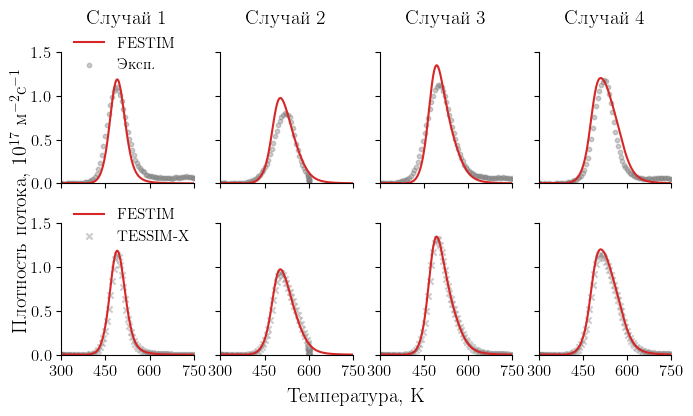

In [11]:
fig, axs = plt.subplots(
    2, 4, figsize=(200 * mm2inch, 100 * mm2inch), sharex=True, sharey=True
)

titles = [
    "Случай 1",
    "Случай 2",
    "Случай 3",
    "Случай 4",
]
for i, prms in enumerate(params):

    T, FESTIM_flux = total_flux(results[i])
    exp_label = prms["exp_data"]

    ref_data = json.load(open(f"./reference_data/{exp_label}.json"))

    axs[0][i].scatter(
        np.array(ref_data["temptab"][::5]),
        np.array(ref_data["experiment"][::5]) / 1e5,
        marker="o",
        s=10,
        alpha=0.4,
        color="grey",
    )

    axs[1][i].scatter(
        np.array(ref_data["temptab"][::5]),
        np.array(ref_data["simflux"][::5]) / 1e5,
        marker="x",
        s=20,
        alpha=0.4,
        color="grey",
    )

    axs[0][i].plot(T, FESTIM_flux / 1e17, lw=1.5, color="tab:red")
    axs[1][i].plot(T, FESTIM_flux / 1e17, lw=1.5, color="tab:red")

    axs[0][i].set_title(titles[i], y=1.15)


axs[0][0].plot(0, 0, label="FESTIM", lw=1.5, color="tab:red")
axs[0][0].scatter(0, 0, label="Эксп.", marker="o", s=10, alpha=0.4, color="grey")
axs[0][0].legend(loc=(0.05, 0.8), fontsize=11)

axs[1][0].plot(0, 0, label="FESTIM", lw=1.5, color="tab:red")
axs[1][0].scatter(0, 0, label="TESSIM-X", marker="x", s=20, alpha=0.4, color="grey")
axs[1][0].legend(loc=(0.05, 0.8), fontsize=11)


axs[0][0].set_xlim(300, 750)
axs[0][0].set_ylim(0, 1.5)
axs[0][0].set_xticks([300, 450, 600, 750])
fig.supxlabel("Температура, К", y=-0.02)
fig.supylabel(r"Плотность потока, $10^{17}$ м$^{-2}$с$^{-1}$", x=0.06)

fig.subplots_adjust(hspace=0.3)

plt.savefig("../../../Thesis/images/val4.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

We can evaluate RMSE between simulation and experimental results. We will compute a global RMSE, since all TDS curves were fitted with the same set of input parameters.

**Note:** For the **DPA $\rightarrow$ 48 h plasma** case, RMSE is calculated only up to 600 K.

In [7]:
from scipy.interpolate import interp1d


def RMSE(x1, x2):
    error = np.sqrt(np.mean((x1 - x2) ** 2))
    return error

In [8]:
for i, prms in enumerate(params):

    T, FESTIM_flux = total_flux(results[i])

    # Experimental data
    ref_data = json.load(open(f"./reference_data/{prms['exp_data']}.json"))

    exp_Flux = np.array(ref_data["experiment"]) * 1e12
    exp_T = np.array(ref_data["temptab"])

    interp_tds = interp1d(T, FESTIM_flux, fill_value="extrapolate")

    if i == 0:
        data_FESTIM = interp_tds(exp_T)
        data_exp = exp_Flux
    elif i == 1:
        data_FESTIM = np.concatenate(
            [data_FESTIM, interp_tds(exp_T[np.where(exp_T < 600)])]
        )
        data_exp = np.concatenate([data_exp, exp_Flux[np.where(exp_T < 600)]])
    else:
        data_FESTIM = np.concatenate([data_FESTIM, interp_tds(exp_T)])
        data_exp = np.concatenate([data_exp, exp_Flux])

error = RMSE(data_FESTIM, data_exp)
print(f"Global RMSE between FESTIM and experiment is {error:.5e} 1/m^2 s")

Global RMSE between FESTIM and experiment is 7.90105e+15 1/m^2 s


We can also evaluate RMSE between FESTIM and TESSIM-X results. 

In [9]:
for i, prms in enumerate(params):

    T, FESTIM_flux = total_flux(results[i])

    # Experimental data
    ref_data = json.load(open(f"./reference_data/{prms['exp_data']}.json"))

    TESSIM_Flux = np.array(ref_data["simflux"]) * 1e12
    exp_T = np.array(ref_data["temptab"])

    interp_tds = interp1d(T, FESTIM_flux, fill_value="extrapolate")

    if i == 0:
        data_FESTIM = interp_tds(exp_T)
        data_TESSIM = TESSIM_Flux
    elif i == 1:
        data_FESTIM = np.concatenate(
            [data_FESTIM, interp_tds(exp_T[np.where(exp_T < 600)])]
        )
        data_TESSIM = np.concatenate([data_TESSIM, TESSIM_Flux[np.where(exp_T < 600)]])
    else:
        data_FESTIM = np.concatenate([data_FESTIM, interp_tds(exp_T)])
        data_TESSIM = np.concatenate([data_TESSIM, TESSIM_Flux])

error = RMSE(data_FESTIM, data_TESSIM)
print(f"Global RMSE={error:.5e} 1/m^2 s")

Global RMSE=2.58896e+15 1/m^2 s
